# PBR (Physically-Based Rendering) Material Creator

<a target="_blank" href="https://colab.research.google.com/github/simonguest/CS-394/blob/main/src/04/notebooks/pbr-creator.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://github.com/simonguest/CS-394/raw/refs/heads/main/src/04/notebooks/pbr-creator.ipynb">
  <img src="https://img.shields.io/badge/Download_.ipynb-blue" alt="Download .ipynb"/>
</a>

## Dependencies

In [ ]:
!uv pip install -q replicate

## Set Replicate API Token

In [1]:
import sys
import os
from dotenv import load_dotenv

if 'google.colab' in sys.modules:
  from google.colab import userdata # type:ignore
  REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')
else:
  load_dotenv()
  REPLICATE_API_TOKEN = os.getenv('REPLICATE_API_TOKEN')

## Create the Replicate client

In [2]:
import replicate
import io
from PIL import Image

client = replicate.Client(api_token=REPLICATE_API_TOKEN)

## Load the control image

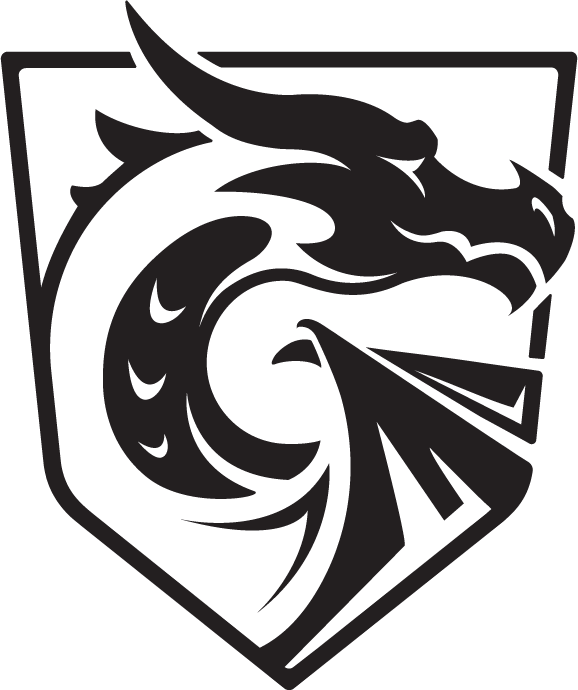

In [14]:
CONTROL_IMAGE = "https://raw.githubusercontent.com/simonguest/CS-394/refs/heads/main/src/04/images/dragon.png"

control = open("../images/dragon.png", "rb")
control_bytes = io.BytesIO(control.read())
control_image = Image.open(control_bytes)
control_image


## Run control image through FLUX Pro (controlled by Canny edge detection)

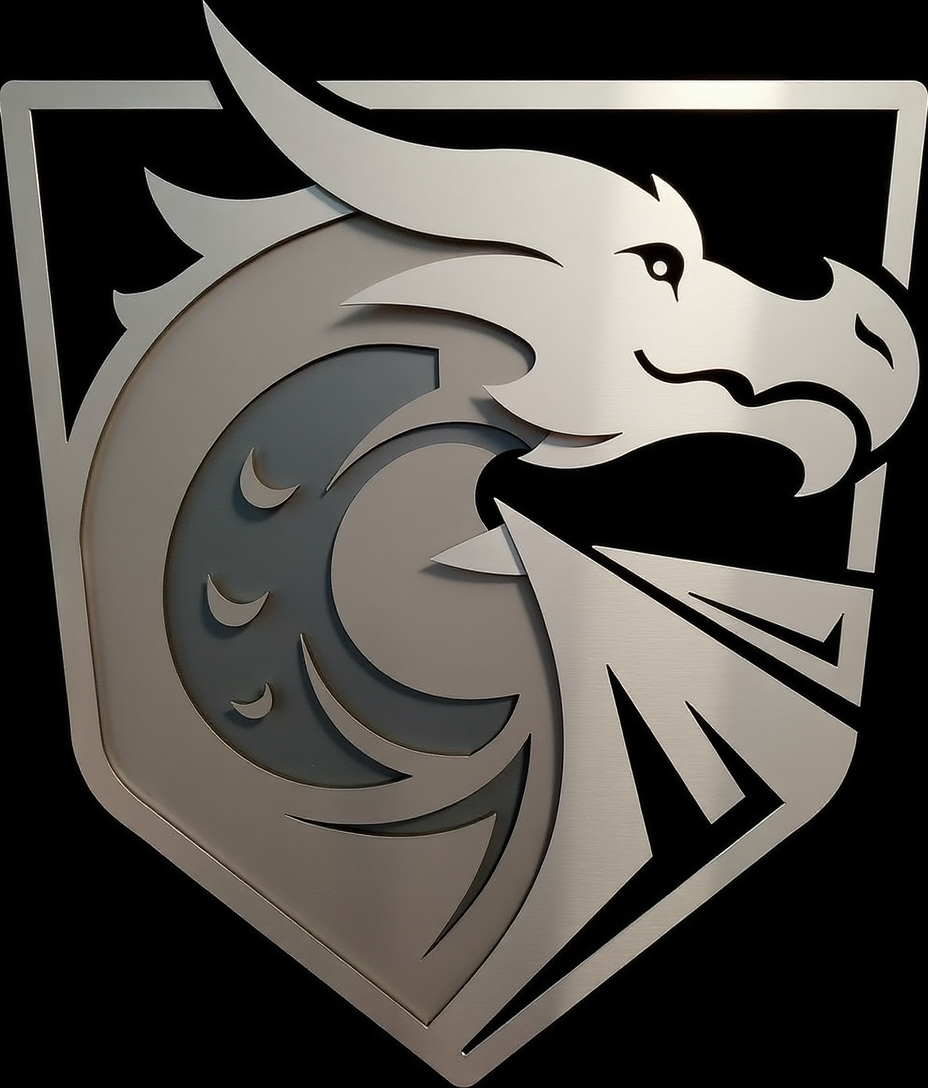

In [21]:
# @title Run initial image through FLUX Pro (controlled by Canny edge detection)

output = client.run(
    "black-forest-labs/flux-canny-pro",
    input={
        "steps": 28,
        "seed": 1234567, # Fix the seed so that the image is reproducible
        "prompt": "a metal embossed dragon, cinematic lighting",
        "guidance": 30,
        "control_image": control,
        "output_format": "png",
        "safety_tolerance": 2,
        "prompt_upsampling": False
    }
)

output_bytes = io.BytesIO(output.read())
output_image = Image.open(output_bytes)
output_image

## Tile the image using FLUX schnell and ideogram inpainting

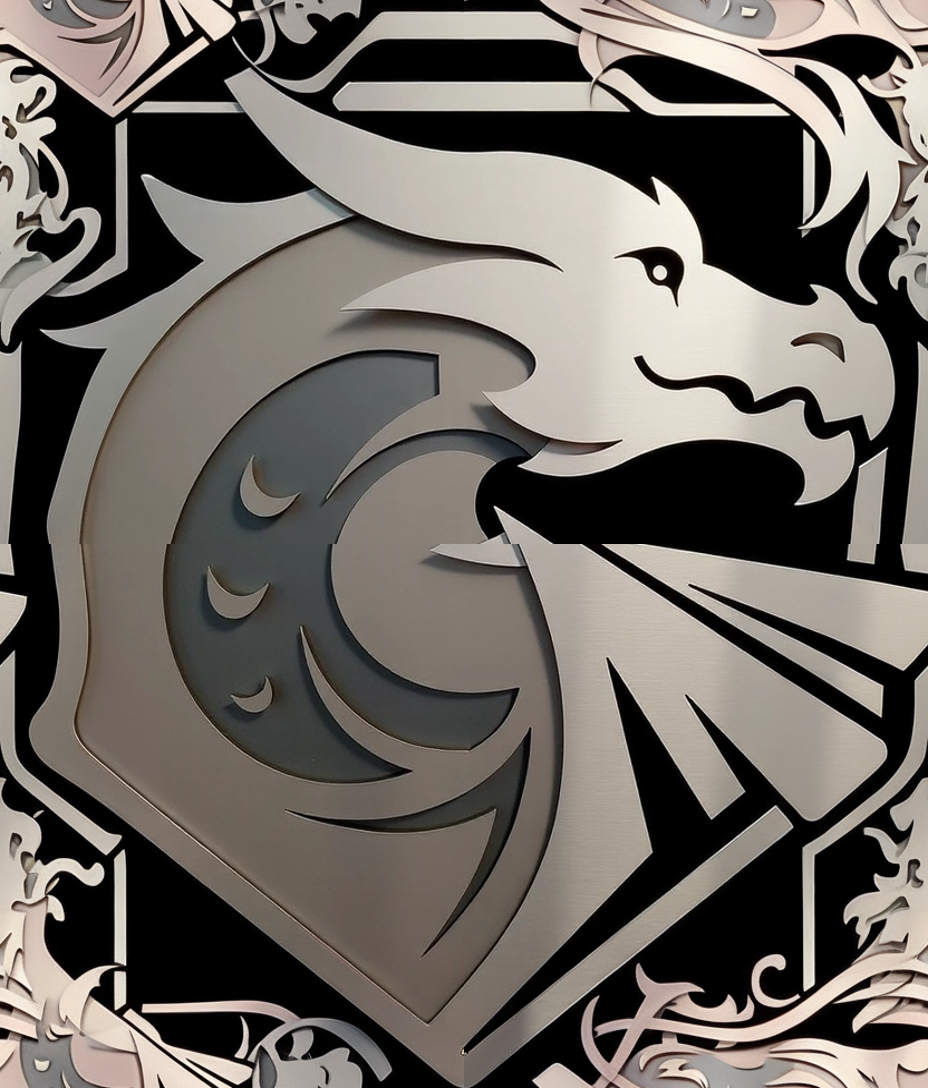

In [ ]:
tiled = client.run(
  "pipeline-examples/tile",
  input={
      "model": "black-forest-labs/flux-schnell",
      "prompt": "a network of interconnected dragons",
      "input_image": output_bytes,
      "inpaint_model": "ideogram",
      "seam_percentage": 30
  }
)

tiled_bytes = io.BytesIO(tiled.read())
tiled_image = Image.open(tiled_bytes)
tiled_image

## Generate a depth map using Depth Anything

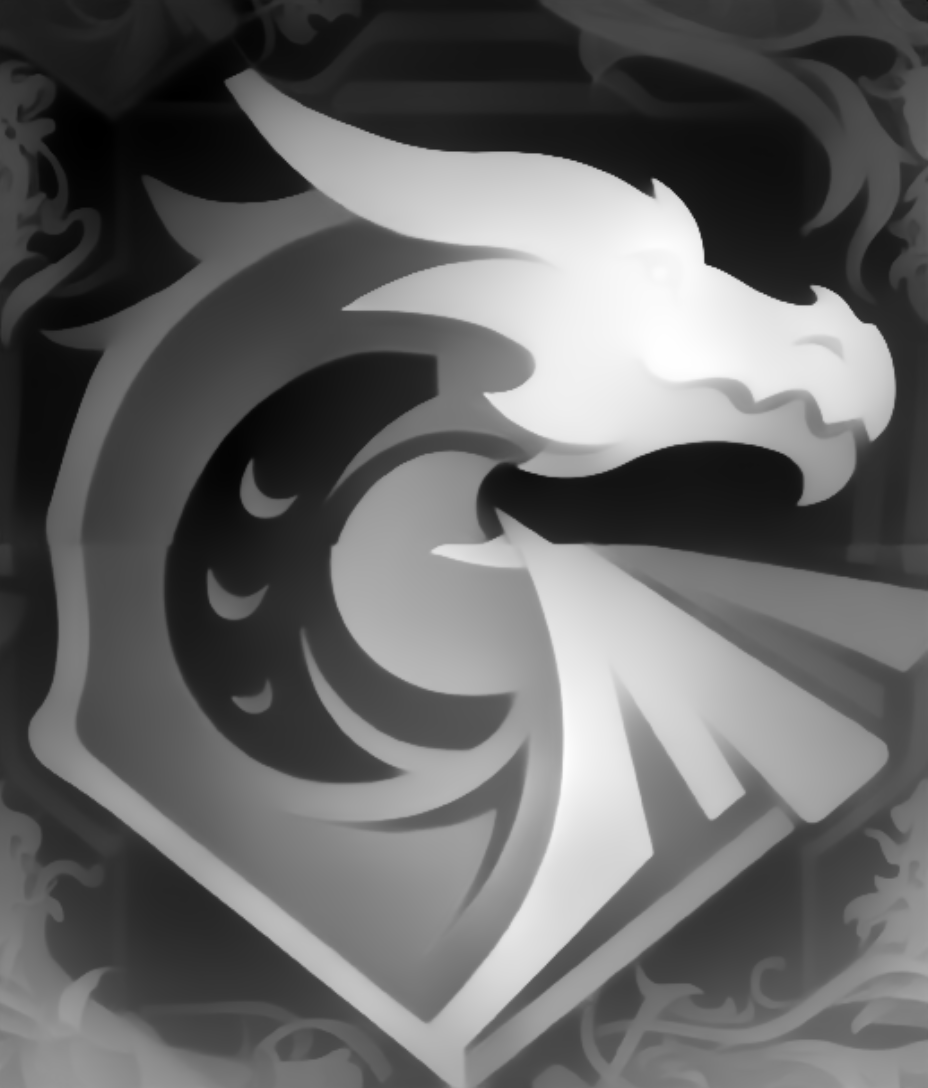

In [23]:
depth = client.run(
    "chenxwh/depth-anything-v2:b239ea33cff32bb7abb5db39ffe9a09c14cbc2894331d1ef66fe096eed88ebd4",
    input={
        "image": tiled_bytes,
        "model_size": "Large"
    }
)

depth_bytes = io.BytesIO(depth["grey_depth"].read())
depth_image = Image.open(depth_bytes)
depth_image


## Convert the depth map to a normal map for PBR

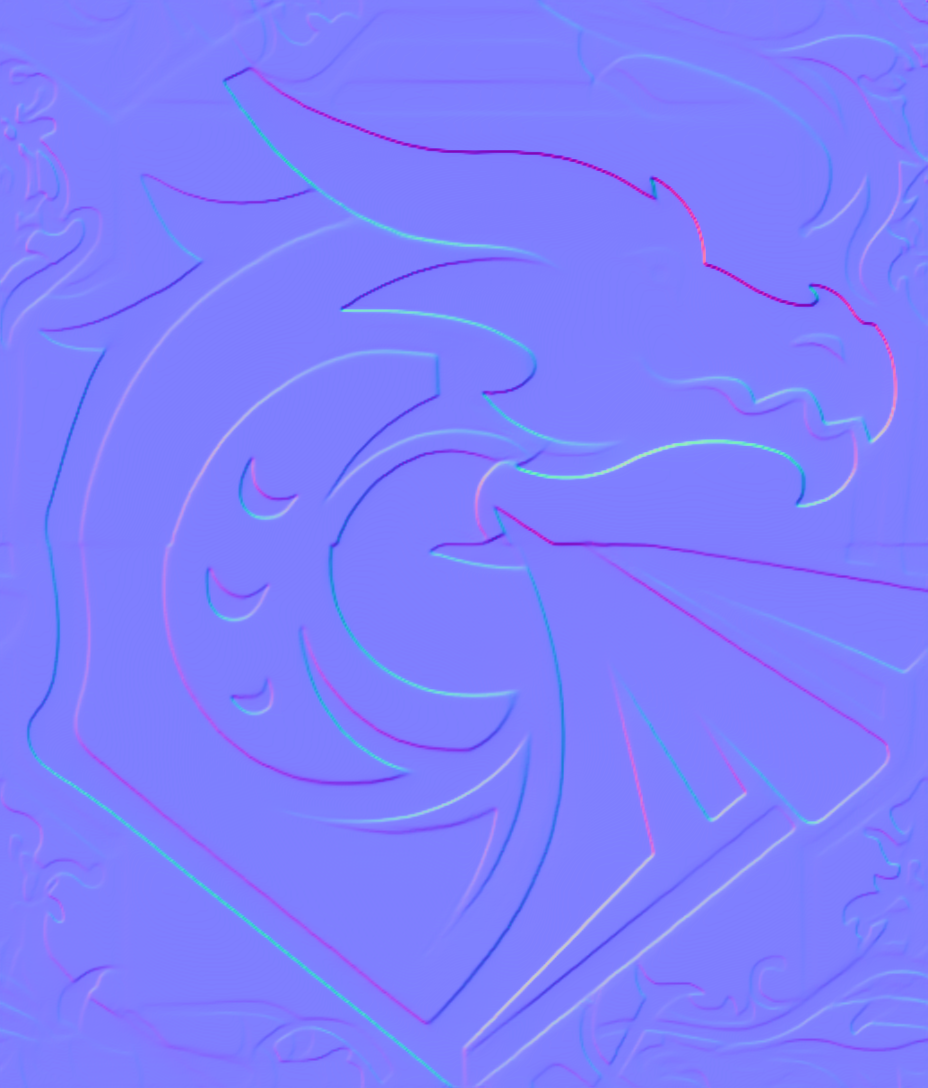

In [24]:
import numpy as np

def depth_to_normal(depth_image, strength=1.0):
    depth_array = np.array(depth_image, dtype=np.float32) / 255.0

    # Calculate gradients (sobel-like operators)
    # Sobel kernels for x and y directions
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]]) * strength

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]]) * strength

    # Pad the depth array to handle edges
    padded_depth = np.pad(depth_array, 1, mode='edge')

    # Initialize normal map components
    height, width = depth_array.shape
    dx = np.zeros((height, width))
    dy = np.zeros((height, width))

    # Calculate gradients using convolution
    for i in range(height):
        for j in range(width):
            region = padded_depth[i:i+3, j:j+3]
            dx[i, j] = np.sum(region * sobel_x)
            dy[i, j] = np.sum(region * sobel_y)

    # Create normal vectors
    # In tangent space: x points right, y points down, z points out
    # Normal = normalize(-dx, -dy, 1)
    dz = np.ones_like(dx)

    # Calculate magnitude for normalization
    magnitude = np.sqrt(dx*dx + dy*dy + dz*dz)

    # Normalize the vectors
    nx = -dx / magnitude
    ny = -dy / magnitude
    nz = dz / magnitude

    # Convert from [-1, 1] to [0, 255] for RGB channels
    # R = X, G = Y, B = Z
    normal_map = np.zeros((height, width, 3), dtype=np.uint8)
    normal_map[:, :, 0] = ((nx + 1) * 0.5 * 255).astype(np.uint8)  # Red (X)
    normal_map[:, :, 1] = ((ny + 1) * 0.5 * 255).astype(np.uint8)  # Green (Y)
    normal_map[:, :, 2] = ((nz + 1) * 0.5 * 255).astype(np.uint8)  # Blue (Z)

    # Save the normal map
    normal_img = Image.fromarray(normal_map)

    return normal_img

normal_image = depth_to_normal(depth_image.convert('L'), strength=1.0)
normal_image


## Save files

In [ ]:
tiled_image.save("dragon_tiled.png")
normal_image.save("dragon_normal.png")